In [32]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

path = "pick_10_1_objs_va_high_cam_real.hdf5"
data = h5py.File(path, 'r')

In [33]:
def depth_to_points(depth, intrinsic, extrinsic, depth_scale=1000.0):
    height, width = depth.shape[:2]
    depth = depth.squeeze() / depth_scale
    xlin = np.linspace(0, width - 1, width)
    ylin = np.linspace(0, height - 1, height)
    px, py = np.meshgrid(xlin, ylin)
    px = (px - intrinsic[0, 2]) * (depth / intrinsic[0, 0])
    py = (py - intrinsic[1, 2]) * (depth / intrinsic[1, 1])
    points = np.stack((px, py, depth, np.ones(depth.shape)), axis=-1)
    points = (extrinsic @ points.reshape(-1, 4).T).T
    points = points[:, :3]
    return points

sim_points = []
sim_colors = []
for rgb, depth, intrinsic, extrinsic in zip(data["data"]["demo_0"]["obs_sim"]["rgb"], data["data"]["demo_0"]["obs_sim"]["depth"], data["data"]["demo_0"]["obs_sim"]["camera_intrinsic"], data["data"]["demo_0"]["obs_sim"]["camera_extrinsic"]):
    H, W = depth.shape
    point = depth_to_points(depth.reshape(H, W), intrinsic.reshape(3, 3), extrinsic.reshape(4, 4), depth_scale=1000.)
    point = point.reshape(H, W, 3)
    color = rgb.reshape(H, W, 3) / 255.
    sim_points.append(point)
    sim_colors.append(color)

sim_points = np.stack(sim_points, axis=0)
sim_colors = np.stack(sim_colors, axis=0)

real_points = []
real_colors = []
for rgb, depth, intrinsic, extrinsic in zip(data["data"]["demo_0"]["obs_real"]["rgb"], data["data"]["demo_0"]["obs_real"]["depth"], data["data"]["demo_0"]["obs_real"]["camera_intrinsic"], data["data"]["demo_0"]["obs_real"]["camera_extrinsic"]):
    H, W = depth.shape
    point = depth_to_points(depth.reshape(H, W), intrinsic.reshape(3, 3), extrinsic.reshape(4, 4), depth_scale=1000.)
    point = point.reshape(H, W, 3)
    color = rgb.reshape(H, W, 3) / 255.
    real_points.append(point)
    real_colors.append(color)

real_points = np.stack(real_points, axis=0)
real_colors = np.stack(real_colors, axis=0)

sim_qpos = data["data"]["demo_0"]["obs_sim"]["qpos"]
real_qpos = data["data"]["demo_0"]["obs_real"]["qpos"]

In [40]:
path = "/home/memmelma/Projects/robotic/gifs_curobo/pick_1000_1_objs_va_high_cam.hdf5"
data = h5py.File(path, 'r')

sim_points = []
sim_colors = []
for rgb, depth, intrinsic, extrinsic in zip(data["data"]["demo_0"]["obs"]["rgb"], data["data"]["demo_0"]["obs"]["depth"], data["data"]["demo_0"]["obs"]["camera_intrinsic"], data["data"]["demo_0"]["obs"]["camera_extrinsic"]):
    H, W = depth.shape
    point = depth_to_points(depth.reshape(H, W), intrinsic.reshape(3, 3), extrinsic.reshape(4, 4), depth_scale=1000.)
    point = point.reshape(H, W, 3)
    color = rgb.reshape(H, W, 3) / 255.
    sim_points.append(point)
    sim_colors.append(color)

sim_points = np.stack(sim_points, axis=0)
sim_colors = np.stack(sim_colors, axis=0)

sim_qpos = data["data"]["demo_0"]["obs"]["qpos"]

In [ ]:
import json
env_config = json.loads(data["data"].attrs["env_args"])["env_kwargs"]

from problem_reduction.robot.robot_env import CubeEnv
env = CubeEnv(**env_config)
env_obs = env.reset()

plt.imshow(np.concatenate([sim_colors[0], real_colors[0], env_obs["rgb"] / 255., sim_colors[0] - real_colors[0]], axis=1))
"       |   sim (data)    |     real (data)   |     sim (env)     |     sim - real |"

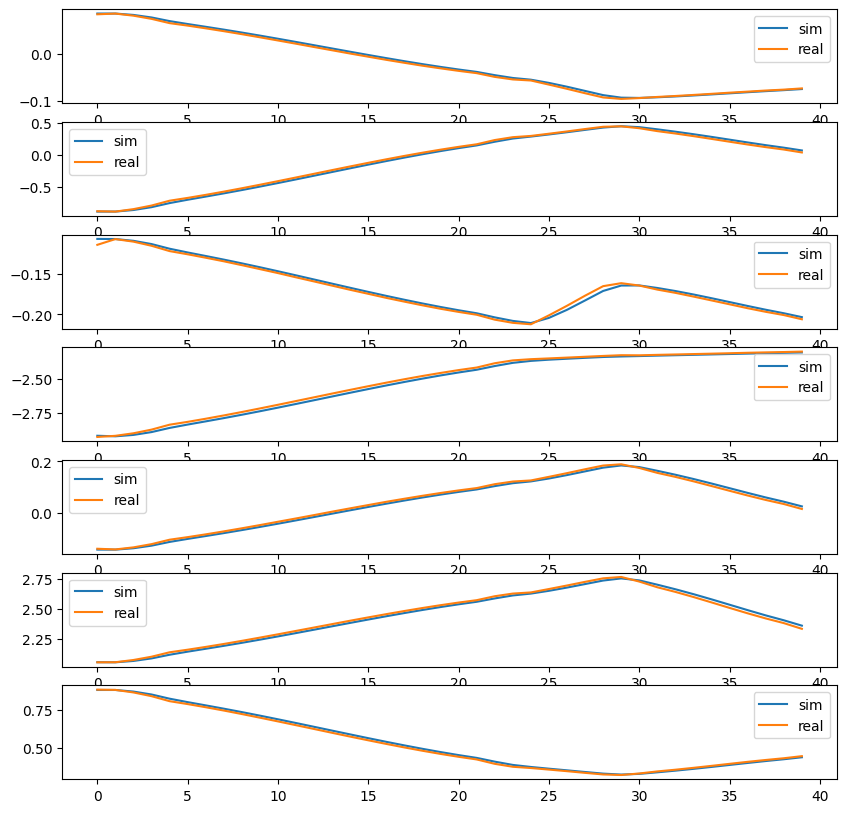

In [20]:
# plot qpos, one subplot per dim
plt.figure(figsize=(10, 10))
for i in range(sim_qpos.shape[1]):
    plt.subplot(sim_qpos.shape[1], 1, i+1)
    plt.plot(sim_qpos[:, i], label="sim")
    plt.plot(real_qpos[:, i], label="real")
    plt.legend()


In [ ]:
from problem_reduction.points.meshcat import create_visualizer, visualize_pointcloud
vis = create_visualizer()


import time
while True:
    for i in range(real_points.shape[0]):
        visualize_pointcloud(
            vis, 'points_real',
            pc=real_points[i],
            color=np.ones_like(real_points[i]) * [255., 0., 0.],
            # color=real_colors[i] * 255.,
            size=0.01
        )
        visualize_pointcloud(
            vis, 'points_sim',
            pc=sim_points[i],
            # color=sim_colors[i] * 255.,
            color=np.ones_like(sim_points[i]) * [0., 0., 255.],
            size=0.01
        )
        time.sleep(0.1)

Waiting for meshcat server... have you started a server? Run `meshcat-server` to start a server
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


KeyboardInterrupt: 